# Case Studies in Bioinformatics
_Cyril Matthey-Doret, December 2016_

## Background

Ontogeny is the development of an organism from egg fertilization to its mature state. It requires expression of different genes at each stage of development, associated with phenotypic changes. There is a lot of discussion on how these sets of genes differ between species. The earliest studies of embryogenesis performed by Karl Ernst Ritter von Baer in the 19th century suggested that the most similar state of development between related species, also known as the phylotypic stage, happens at the earliest stages of embryogenesis. This lead to what is called the funnel model. However, more recent work has shown that this convergence happens later, earliest stages being more different between species, giving rise to the hourglass model. It is now possible to test these models by combining gene expression data at different stages of embryogenesis and phylogenetic information for the concerned genes to better study the differences between species. Here, I investigate a study relying on an approach termed phylostratigraphy, which consists in tracing the origin of specific genes through similarity searches. This allows to build a phylogenetic tree where each gene has a rank that estimates their age. These ranks can be used to get a metric of age for the whole transcriptome at each developmental stage, called Transcriptome Age Index (TAI). Results obtained in this study support the hourglass model, focusing on expression datasets from the zebrafish _Danio rerio_, Drosophilia, the mosquito _Anopheles_ and the nematode _Caenorhabditis elegans_. In this report, I use forensic bioinformatics to repeat the analysis from [Domazet-Lošo et Tautz, 2010](http://www.nature.com/nature/journal/v468/n7325/full/nature09632.html) to have a critical view of each step and a better understanding of their results. Finally, I propose improvements for the analysis, explaining how it would affect the results.

## Methods

I reproduced the analysis from the paper using python 2 with the modules panda, numpy, matplotlib and GEOparse. I used expression data from _Danio rerio_ (zebrafish) to reproduce the results shown in figure 1a of the paper. Expression data for zebrafish was obtained from [Domazet-Lošo et Tautz (2010)](http://www.nature.com/nature/journal/v468/n7325/full/nature09632.html) and phylostrata were obtained from [Šestak et al, 2013](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3636138/). The first step was to load the expression data from microarray and extract meaningful informations for each sample (developmental stage, age and sex). The expression data was then formatted and annotated with microarray spot ID using the GEO platform (GPL) annotation file. Throughout the whole report, "expression" refers to the microarray signal intensity value and therefore has no unit.

In [2]:
#!pip install GEOparse

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import GEOparse

probes_conv = GEOparse.parse_GSM("/home/cyril/Documents/Master/sem_1/Case_study/module1/data/GPL6457_old_annotations.txt.gz")

try:
    gse = GEOparse.get_GEO(filepath="./GSE24616.soft.gz", silent=True)
except IOError:
    gse = GEOparse.get_GEO("GSE24616",destdir="./", silent=True)
# Using GEOparse inbuilt tools to parse the Gene series expression data for zebrafish.
# If the file is not found, it is downloaded first, otherwise it is parsed directly

char = {"stage": [], "time": [], "sex": [], "sample_name": []}
# Initializing dictionary object to store metadata

for gsm_name, gsm in sorted(gse.gsms.iteritems()): 
    char["stage"].append(gsm.metadata['characteristics_ch1'][1].split(": ")[1])
    char["time"].append(gsm.metadata['characteristics_ch1'][2].split(": ")[1])
    char["sex"].append(gsm.metadata['characteristics_ch1'][3].split(": ")[1])
    char["sample_name"].append(gsm.name)
# Formatting parsed metadata in a structured dictionary object

GPL = gse.gpls.values()[0]
# Getting spots IDs from platform annotation file
pivoted_samples = gse.pivot_samples('VALUE')
# Samples as columns
pivoted_samples.set_index(GPL.table.SPOT_ID, inplace=True)
# Setting indexes as microarray spot ID


Parsing ./GSE24616.soft.gz:
Parsing ./GSE24616.soft.gz:
 - DATABASE : GeoMiame
 - SERIES : GSE24616
 - PLATFORM : GPL6457
 - SAMPLE : GSM606866
 - SAMPLE : GSM606867
 - SAMPLE : GSM606868
 - SAMPLE : GSM606869
 - SAMPLE : GSM606870
 - SAMPLE : GSM606871
 - SAMPLE : GSM606872
 - SAMPLE : GSM606873
 - SAMPLE : GSM606874
 - SAMPLE : GSM606875
 - SAMPLE : GSM606876
 - SAMPLE : GSM606877
 - SAMPLE : GSM606878
 - SAMPLE : GSM606879
 - SAMPLE : GSM606880
 - SAMPLE : GSM606881
 - SAMPLE : GSM606882
 - SAMPLE : GSM606883
 - SAMPLE : GSM606884
 - SAMPLE : GSM606885
 - SAMPLE : GSM606886
 - SAMPLE : GSM606887
 - SAMPLE : GSM606888
 - SAMPLE : GSM606889
 - SAMPLE : GSM606890
 - SAMPLE : GSM606891
 - SAMPLE : GSM606892
 - SAMPLE : GSM606893
 - SAMPLE : GSM606894
 - SAMPLE : GSM606895
 - SAMPLE : GSM606896
 - SAMPLE : GSM606897
 - SAMPLE : GSM606898
 - SAMPLE : GSM606899
 - SAMPLE : GSM606900
 - SAMPLE : GSM606901
 - SAMPLE : GSM606902
 - SAMPLE : GSM606903
 - SAMPLE : GSM606904
 - SAMPLE : GSM60690

Next, I imported the phylostrata and merged it with expression data by spot ID. Since the phylostrata data file contains both spots ID and associated genes ID, there is no need for an additional conversion step. As certain genes were represented multiple times, I used the mean expression for these genes in each sample.

In [10]:

strata = pd.read_csv("./phylostrata.txt", sep="\t", header=None)
strata.columns = ["GeneID", "ProbeID", "age"]
strata.set_index("ProbeID", inplace=True)
# Loading and formatting phylostrata with matching genes ID, probe ID and gene age

matched_data = pivoted_samples.join(strata, how="inner").groupby(level=0).last()
# Joining expression data with phylostrata by probe ID. 
# If the same probe ID is listed several times, only one occurence is used.

unique_data = matched_data.groupby("GeneID").mean()
# Taking the mean expression values for all genes.

char_pd = pd.DataFrame(char, index=char["sample_name"])
# New dataframe object containing meta-data with sample names as row indexes.
mixed = char_pd[char_pd.sex == "mixed"].sample_name.tolist()
mixed += char_pd[char_pd.sex == "female"].sample_name.tolist()
# Extracting all non-male sample names.

char_pd["timing_number"] = 0
# Initiating new column to store developmental time stamps
time_stamps = char_pd.time.unique()
for i in xrange(len(time_stamps)):
    char_pd.loc[char_pd.time == time_stamps[i], "timing_number"] = i + 1
# Assigning developmental time stamps

experiment_index = char_pd[char_pd.index.isin(mixed)].reset_index().groupby("timing_number")["index"].apply(
    lambda x: np.array(x))
# Dataframe with samples grouped by timestamps

set_mean = {}
stages = []
for d, col_list in experiment_index.iteritems():
    set_mean[d] = unique_data[col_list].mean(axis=1)
    # Storing mean expression of all samples at with a given time stamp
    stages.append(char_pd[char_pd.index.isin(col_list)].stage[0])
    # Storing developmental stage matching time stamp

mean_data = pd.DataFrame(set_mean)
# Builds dataframe containing mean expression of all genes at each time stamp


From this data structure containing the mean expression of every gene at each development stage, I calculated the transcriptome age index (TAI) at each time stamp "s", as described in the paper methods: \begin{equation*}TAI_s=\frac{\sum_{i=1}^n ps_ie_i}{\sum_{i=1}^n e_i}\end{equation*} where $ps_i$ is the phylostratum of gene i and $e_i$ is its expression.

<IPython.core.display.Javascript object>


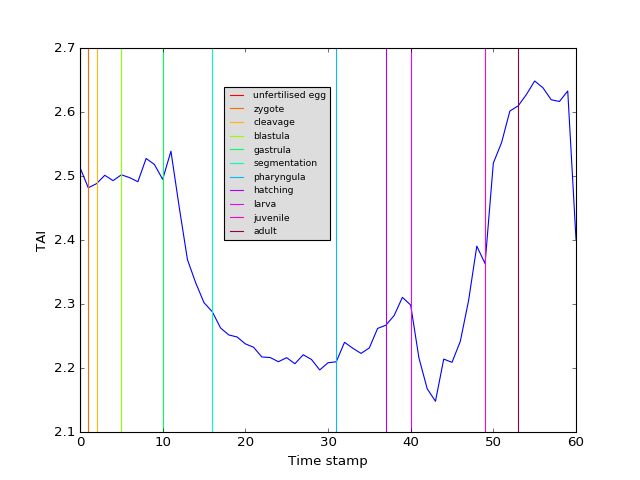

In [22]:
%matplotlib notebook

TAI = []
# List used to store TAI for each time stamp
for s in mean_data.iteritems():
    expr_sum = sum(s[1])
    # Sums all expressions at given time stamp
    gcount = 0
    # Counts number of genes in transcriptome
    gene_TAI = 0
    # Stores the weighted sum of phylostrata (age rank)
    for r in s[1]:
        gene_TAI += r*unique_data.age[gcount]
        # Summing products of age rank by expression
        gcount += 1
    TAI.append(gene_TAI/expr_sum)
    # Normalizing by total expression

plt.plot(TAI)
plt.xlabel("Time stamp")
plt.ylabel("TAI")
my_colorlist = ['#ff0000', '#ff6a00', '#ffb700', '#91ff00', '#00ff59',
                '#00ffbf', '#00bbff', '#aa00ff', '#e205ff','#ff05c9',
                '#940047']
def order_uniq(seq):
    # Function allowing to get each unique list element and preserve the order
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

col_count = 0
for t in order_uniq(stages):
    plt.axvline(x=stages.index(t), color=my_colorlist[col_count], label=t)
    # Adding vertical line representing start of developmental stages
    col_count += 1

legend = plt.legend(loc=(0.29,0.5), shadow=False, fontsize='x-small')
legend.get_frame().set_facecolor('#dddddd')


When plotting the TAIs calculated as described in the paper, I obtained rather similar results to figure 1a. On the figure presented in this report, the vertical lines represent the earliest time stamp at which a developmental stage was observed. This figure depicts what one would expect from the hourglass model, as the lowest TAIs (i.e. the transcriptome with the oldest genes) are located in the middle, from the segmentation to the larval states.

However, there is an issue in the way gene expression values affect the TAI. Distributions of gene expressions are usually made of many lowly expressed genes, and a few outliers that are highly expressed.  Since the TAI directly depends on the product of gene expression by phylostrata, those few outliers will dictate the TAIs. 

The plot below shows the whole gene expression data in the zebrafish dataset. As expected, Most genes have low expression values, and there are outliers with much higher values (the maximum expression observed was 388'818.64).

<IPython.core.display.Javascript object>


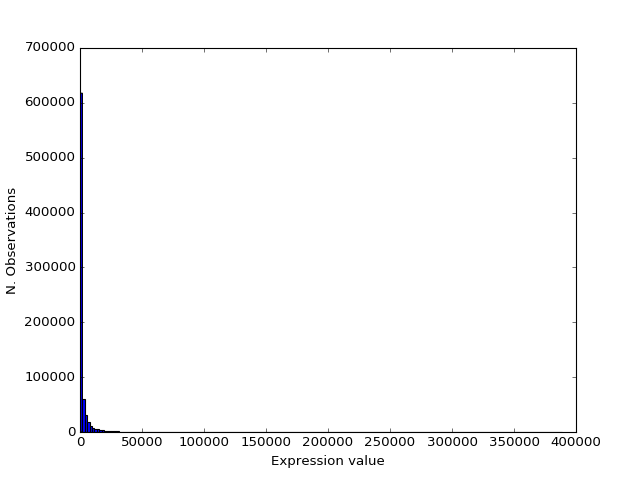

In [37]:
%matplotlib notebook

all_expr = mean_data.values.tolist()
allflat = [item for sublist in all_expr for item in sublist]
# Extracting all expression values in each dataset
histo = plt.hist(allflat, bins=200)
plt.show(histo)
plt.xlabel("Expression value");
plt.ylabel("N. Observations");


A common way to solve the outlier problem is to log-transform the expression values. This reduces the distance with outliers and would be interesting here, as this would reduce the weight of strongly expressed genes on the TAI. The distribution of log transformed expression looks like this: 

<IPython.core.display.Javascript object>


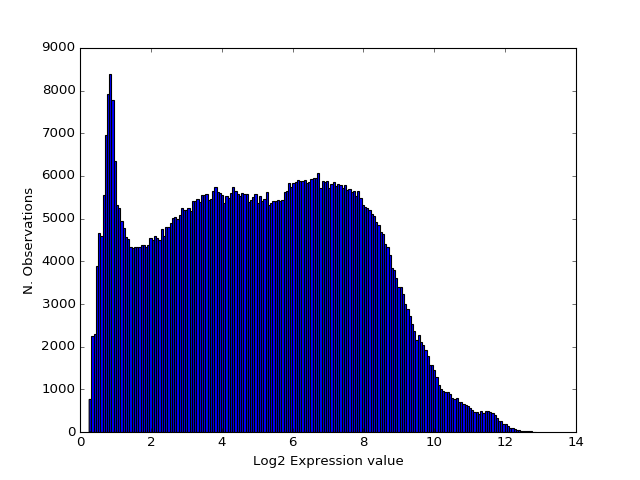

In [36]:
%matplotlib notebook

log_exp = np.log(mean_data.values)
# Log-transforming expression
log_expr = log_exp.tolist()
logflat = [item for sublist in log_exp for item in sublist]
# Extracting all expression values in each dataset
loghist = plt.hist(logflat, bins=200)
plt.show(loghist)
plt.xlabel("Log2 Expression value");
plt.ylabel("N. Observations");

Finally, I recalculated the TAI using this log-transformed expression data: 

<IPython.core.display.Javascript object>


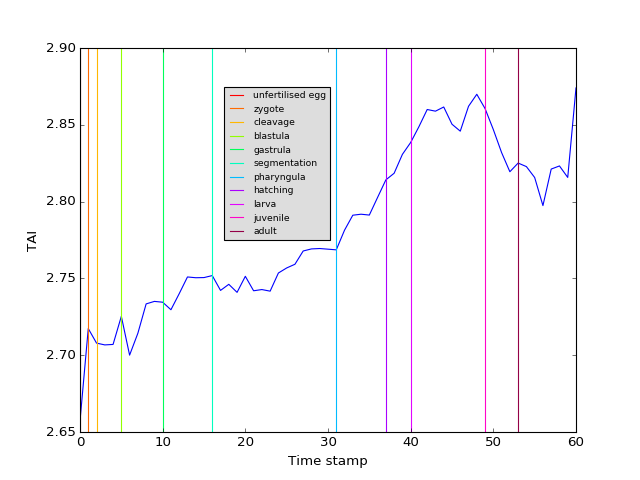

In [38]:
%matplotlib notebook

TAI = []
# List used to store TAI for each time stamp
for s in np.log(mean_data).iteritems():
    expr_sum = sum(s[1])
    # Sums all log-transformed expressions at given time stamp
    gcount = 0
    # Counts number of genes in transcriptome
    gene_TAI = 0
    # Stores the weighted sum of phylostrata (age rank)
    for r in s[1]:
        gene_TAI += r * unique_data.age[gcount]
        # Summing products of age rank by log-expression
        gcount += 1
    TAI.append(gene_TAI / expr_sum)
    # Normalizing by total log-expression
plt.plot(TAI)
plt.xlabel("Time stamp")
plt.ylabel("TAI")
my_colorlist = ['#ff0000', '#ff6a00', '#ffb700', '#91ff00', '#00ff59',
                '#00ffbf', '#00bbff', '#aa00ff', '#e205ff','#ff05c9',
                '#940047']
def order_uniq(seq):
    # Function allowing to get each unique list element and preserve the order
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

col_count = 0
for t in order_uniq(stages):
    plt.axvline(x=stages.index(t), color=my_colorlist[col_count], label=t)
    # Adding vertical line representing start of developmental stages
    col_count += 1

legend = plt.legend(loc=(0.29,0.5), shadow=False, fontsize='x-small')
legend.get_frame().set_facecolor('#dddddd')



As depicted above, log-transforming the expression dramatically changes the results, showing these outliers genes had a strong impact on the TAI value. The lowest TAI are now at the very begining of development and the transcriptome becomes younger with time. This would be in accordance with the funnel model, proposing that the phylotypic stage is at the very beginning of ontogeny.

## Conclusion

This analysis shows the impact normalization and processing steps can have on the results. In this particular case, it is interesting because the original study supports the hourglass model, while the same analysis with normalized data supports the funnel model.

Calculating TAI without log-transforming yields a biased estimation of transcriptome age as it will be dominated by outlier genes. Therefore, the original results would suggest that strongly expressed genes follow the hourglass model, which is also interesting, however this does not apply when giving more weight to lowly expressed genes.

## References

Šestak, M. S., Božičević, V., Bakarić, R., Dunjko, V., & Domazet-Lošo, T. (2013). Phylostratigraphic profiles reveal a deep evolutionary history of the vertebrate head sensory systems. Frontiers in Zoology, 10, 18. http://doi.org/10.1186/1742-9994-10-18

Domazet-Lošo T, Tautz D. (2010). A phylogenetically based transcriptome age index mirrors ontogenetic divergence patterns. Nature, 468(7325):815-8. http://doi.org/10.1038/nature09632

## Data files

__Zebrafish expression data__: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE24616

__Phylostrata__: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3636138/bin/1742-9994-10-18-S5.xls
